In [1]:
from cobra.io import read_sbml_model
model = read_sbml_model('iCGB21FR.xml')

SBML package 'layout' not supported by cobrapy, information is not parsed
https://juser.fz-juelich.de/record/188973 does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id


In [2]:
# model.annotation

In [3]:
# import html2text

# model_notes = """
# <notes>
#     <body xmlns="http://www.w3.org/1999/xhtml">
#         <h1>Model of <i>Corynebacterium glutamicum</i> ATCC 13032 (Bielefeld)</h1>
#         <p>The bacterium <i>Corynebacterium glutamicum</i> can produce <span style="font-variant: small-caps;">l</span>-glutamic acid under certain growth conditions.
#             <span style="font-variant: small-caps;">l</span>-glutamic acid is used as a flavor enhancer, food supplement, or primary chemical raw material.
#             It, therefore, plays an essential economic role with an annual production of over 2&#189; million tons.
#             Due to metabolic development, the product range of <i>C. glutamicum</i> has been expanded to include all biogenic amino acids, vitamins, and more.
#             Previously published metabolic models of <i>C. glutamicum</i> have been supplemented with new metabolic data and expanded with data from new systems biology programs to result in this consensus model.
#         </p>
#     </body>
# </notes>"""

# print(html2text.html2text(model_notes))

In [4]:
# reaction_kegg_list = []

# for reaction in model.reactions:
    
#     reaction_kegg_list.append({"reaction_id":reaction.id, "reaction.annotation":reaction.annotation})

# #     print(f"reaction.id: {reaction.id}")
# #     print(f"reaction.name: {reaction.name}")
# #     print(f"reaction.annotation: {reaction.annotation}")
        
# #     for reactant in reaction.reactants:
# #         print(f"reactant.id: {reactant.id}")
# #         print(f"reactant.name: {reactant.name}")
# #     print("\n")    

In [5]:
# reaction_kegg_list[0]

In [6]:
# model

In [7]:
def getReactionToGeneAssociation():
    global reaction_to_gene_association
    for reaction in model.reactions:
        for gene in reaction.genes:
            reaction_to_gene_association[reaction.id] = gene.id
    return reaction_to_gene_association


def getGeneToReactionAssociation():
    global reaction_to_gene_association
    global gene_to_reaction_association

    for reaction_id, gene_id in reaction_to_gene_association.items():
        if gene_id not in gene_to_reaction_association:
            gene_to_reaction_association[gene_id] = [reaction_id]
        else:
            gene_to_reaction_association[gene_id].append(reaction_id)

    return gene_to_reaction_association

reaction_to_gene_association = {}
gene_to_reaction_association = {}

reaction_to_gene_association = getReactionToGeneAssociation()
gene_to_reaction_association = getGeneToReactionAssociation()

In [17]:
print(f"reaction_to_gene_association: {len(reaction_to_gene_association)}")
list(reaction_to_gene_association.items())[:15]

reaction_to_gene_association: 1077


[('2MAHMP', 'lcl_NC_006958_1_prot_WP_003855288_1_2949'),
 ('3MBt2pp', 'lcl_NC_006958_1_prot_WP_011013917_1_810'),
 ('3MBt4pp', 'lcl_NC_006958_1_prot_WP_011013917_1_810'),
 ('3OXCOAT', 'lcl_NC_006958_1_prot_WP_003859251_1_2275'),
 ('4ABUTD', 'lcl_NC_006958_1_prot_WP_011015386_1_2669'),
 ('4CMLCL_kt', 'lcl_NC_006958_1_prot_WP_003859243_1_2278'),
 ('4HBHYOX', 'lcl_NC_006958_1_prot_WP_011265680_1_1044'),
 ('4HOXPACt2pp', 'lcl_NC_006958_1_prot_WP_003857140_1_156'),
 ('5DGLCNt2rpp', 'lcl_NC_006958_1_prot_WP_011015481_1_2778'),
 ('AACPS1', 'lcl_NC_006958_1_prot_WP_003859586_1_2138'),
 ('AACPS2', 'lcl_NC_006958_1_prot_WP_003859586_1_2138'),
 ('AACPS3', 'lcl_NC_006958_1_prot_WP_003859586_1_2138'),
 ('AACPS4', 'lcl_NC_006958_1_prot_WP_003859586_1_2138'),
 ('AACPS5', 'lcl_NC_006958_1_prot_WP_003859586_1_2138'),
 ('AACPS6', 'lcl_NC_006958_1_prot_WP_003859586_1_2138')]

# RefSeq

In [18]:
from Bio import Entrez, SeqIO
import re

def getProteinID(full_gene):
    return  "WP_" + re.search(r"WP_(\d{9})", full_gene).group(1) if re.search(r"WP_(\d{9})", full_gene) else None
    
def getProteinInformation(protein_id):
    gene, product, organism = None, None, None
    
    Entrez.email = "haroun162@hotmail.fr"
    handle = Entrez.efetch(db="protein", id=protein_id, rettype="gb", retmode="text")
    record = SeqIO.read(handle, "genbank")
    handle.close()
    
    for feature in record.features:
        if 'gene' in feature.qualifiers:
            gene = feature.qualifiers['gene'][0]        

        if 'product' in feature.qualifiers:
            product = feature.qualifiers['product'][0]        

        if 'organism' in feature.qualifiers:
            organism = feature.qualifiers['organism'][0]        
                
    return protein_id, gene, product, organism

def getProteinIdtoGeneAssociation():
    global reaction_to_gene_association
    global protein_id_to_gene_association
    
    protein_id_to_gene_association = []
    i = 0
    
    print(f"{len(list(gene_to_reaction_association.items()))} protein id to fetch its data")
    for full_gene_name, reactions in list(gene_to_reaction_association.items()):
        if "WP_" in full_gene_name:            
            protein_id, gene, product, organism = getProteinInformation(getProteinID(full_gene_name))
            protein_id_to_gene_association.append([protein_id, gene, product, organism])

            if gene:
                i+=1
                print(f"{protein_id}, {gene}, {product}, {organism}")
                
    print(f"A total number of {i} genes were found from protein ids")
                

In [19]:
getProteinIdtoGeneAssociation()

563 protein id to fetch its data


HTTPError: HTTP Error 500: Internal Server Error

# Ploting section

In [17]:
def getLenOfReactions(gene_to_reaction_association):
    temp_reactions = []
    for gene, reactions in gene_to_reaction_association.items():
        for reaction in reactions:
            if reaction not in temp_reactions:
                temp_reactions.append(reaction)
    return len(temp_reactions)    

gene_to_single_reaction_association = {}
gene_to_double_reaction_association = {}
gene_to_triple_reaction_association = {}
gene_to_quadruple_reaction_association = {}
gene_to_quintuple_reaction_association = {}
gene_to_sextuple_reaction_association = {}
gene_to_septuple_reaction_association = {}
gene_to_octuple_reaction_association = {}
gene_to_nonuple_reaction_association = {}
gene_to_decuple_reaction_association = {}
gene_to_many_reaction_association = {}

for gene, reactions in gene_to_reaction_association.items():
    
    if len(reactions) == 1:
        gene_to_single_reaction_association[gene] = reactions
    
    elif len(reactions) == 2:
        gene_to_double_reaction_association[gene] = reactions

    elif len(reactions) == 3:
        gene_to_triple_reaction_association[gene] = reactions
    
    elif len(reactions) == 4:
        gene_to_quadruple_reaction_association[gene] = reactions

    elif len(reactions) == 5:
        gene_to_quintuple_reaction_association[gene] = reactions

    elif len(reactions) == 6:
        gene_to_sextuple_reaction_association[gene] = reactions
    
    elif len(reactions) == 7:
        gene_to_septuple_reaction_association[gene] = reactions
     
    elif len(reactions) == 8:
        gene_to_octuple_reaction_association[gene] = reactions

    elif len(reactions) == 9:
        gene_to_nonuple_reaction_association[gene] = reactions

    elif len(reactions) == 10:
        gene_to_decuple_reaction_association[gene] = reactions

    else:
        gene_to_many_reaction_association[gene] = reactions

print(f"1:1 control: {len(gene_to_single_reaction_association)} genes controlling {getLenOfReactions(gene_to_single_reaction_association)} reactions")
print(f"1:2 control: {len(gene_to_double_reaction_association)} genes controlling {getLenOfReactions(gene_to_double_reaction_association)} reactions")
print(f"1:3 control: {len(gene_to_triple_reaction_association)} genes controlling {getLenOfReactions(gene_to_triple_reaction_association)} reactions")
print(f"1:4 control: {len(gene_to_quadruple_reaction_association)} genes controlling {getLenOfReactions(gene_to_quadruple_reaction_association)} reactions")
print(f"1:5 control: {len(gene_to_quintuple_reaction_association)} genes controlling {getLenOfReactions(gene_to_quintuple_reaction_association)} reactions")
print(f"1:6 control: {len(gene_to_sextuple_reaction_association)} genes controlling {getLenOfReactions(gene_to_sextuple_reaction_association)} reactions")
print(f"1:7 control: {len(gene_to_septuple_reaction_association)} genes controlling {getLenOfReactions(gene_to_septuple_reaction_association)} reactions")
print(f"1:8 control: {len(gene_to_octuple_reaction_association)} genes controlling {getLenOfReactions(gene_to_octuple_reaction_association)} reactions")
print(f"1:9 control: {len(gene_to_nonuple_reaction_association)} genes controlling {getLenOfReactions(gene_to_nonuple_reaction_association)} reactions")
print(f"1:10 control: {len(gene_to_decuple_reaction_association)} genes controlling {getLenOfReactions(gene_to_decuple_reaction_association)} reactions")

print(f"1:11+ control: {len(gene_to_many_reaction_association)} genes controlling {getLenOfReactions(gene_to_many_reaction_association)} reactions")



1:1 control: 367 genes controlling 367 reactions
1:2 control: 102 genes controlling 204 reactions
1:3 control: 30 genes controlling 90 reactions
1:4 control: 19 genes controlling 76 reactions
1:5 control: 9 genes controlling 45 reactions
1:6 control: 11 genes controlling 66 reactions
1:7 control: 4 genes controlling 28 reactions
1:8 control: 3 genes controlling 24 reactions
1:9 control: 4 genes controlling 36 reactions
1:10 control: 0 genes controlling 0 reactions
1:11+ control: 9 genes controlling 141 reactions


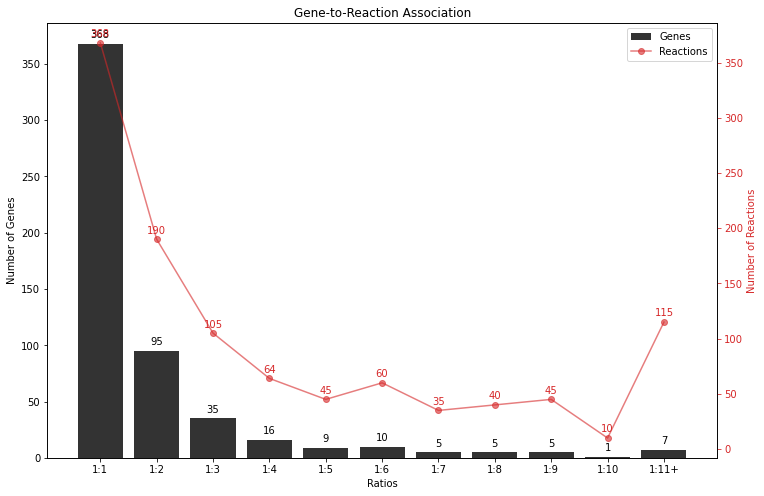

In [18]:
import matplotlib.pyplot as plt

control_ratios = ["1:1", "1:2", "1:3", "1:4", "1:5", "1:6", "1:7", "1:8", "1:9", "1:10", "1:11+"]
num_genes = [368, 95, 35, 16, 9, 10, 5, 5, 5, 1, 7]
num_reactions = [368, 190, 105, 64, 45, 60, 35, 40, 45, 10, 115]

fig, ax1 = plt.subplots(figsize=(12, 8))

color='black'
bars = ax1.bar(control_ratios, num_genes, color=color, alpha=0.8, label='Genes')
ax1.set_xlabel('Ratios')
ax1.set_ylabel('Number of Genes', color=color)
ax1.tick_params('y', colors=color)

for bar, value in zip(bars, num_genes):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+3.5, str(value),
             ha='center', va='bottom', color='black', fontweight='regular')

color = "tab:red"
ax2 = ax1.twinx()
lines = ax2.plot(control_ratios, num_reactions, color=color, marker='o', alpha=0.6, label='Reactions')
ax2.set_ylabel('Number of Reactions', color=color)
ax2.tick_params('y', colors=color)

# Adding labels for reaction values
for x, y, value in zip(ax2.get_xticks(), num_reactions, num_reactions):
    plt.text(x, y+3.5, str(value), ha='center', va='bottom', color=color, fontweight='regular')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Title and show plot
plt.title('Gene-to-Reaction Association')
plt.show()


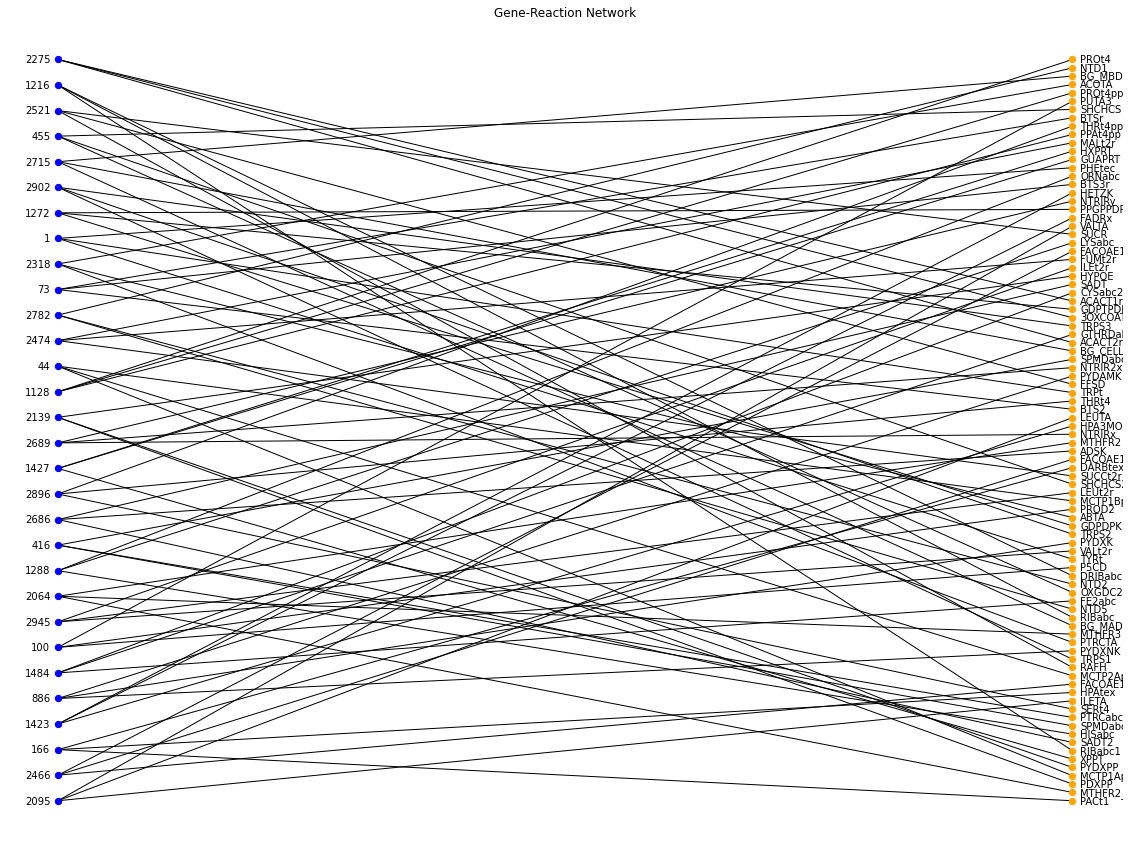

In [19]:
import matplotlib.pyplot as plt
import networkx as nx

def plotGeneReactionNetwork(gene_to_reaction_association):
    G = nx.Graph()
    fig, ax = plt.subplots(figsize=(20, 15))

    # Creating nodes
    for gene, reactions in gene_to_reaction_association.items():
        G.add_node(gene, bipartite=0)
    for reactions in gene_to_reaction_association.values():
        for reaction in set(reactions):
            G.add_node(reaction, bipartite=1)
    
    # Connecting edge
    for gene, reactions in gene_to_reaction_association.items():
        for reaction in set(reactions):
            G.add_edge(gene, reaction)

    gene_nodes = {node for node, data in G.nodes(data=True) if data['bipartite'] == 0}
    reaction_nodes = set(G) - gene_nodes

    pos = nx.bipartite_layout(G, gene_nodes, align='vertical', scale=1, aspect_ratio=1.33)
    
    # Drawing the connecting edge
    nx.draw(G, pos, with_labels=False, node_color="black", node_size=1)

    ## Drawing nodes
    nx.draw_networkx_nodes(G, pos, nodelist=gene_nodes, node_color='blue', node_size=40)    
    nx.draw_networkx_nodes(G, pos, nodelist=reaction_nodes, node_color='orange', node_size=40)

    ## Drawing labels
    gene_labels = {node: node.split("_")[-1] for node in gene_nodes}
    gene_label_pos = {node: (pos[node][0]- 0.01, pos[node][1]) for node in gene_nodes}
    nx.draw_networkx_labels(G, pos=gene_label_pos, labels=gene_labels, font_color='black', font_size=10, horizontalalignment='right', verticalalignment='center')
    reaction_labels = {node: node for node in reaction_nodes}
    reaction_label_pos = {node: (pos[node][0]+ 0.01, pos[node][1]) for node in reaction_nodes}
    nx.draw_networkx_labels(G, pos=reaction_label_pos, labels=reaction_labels, font_color='black', font_size=10, horizontalalignment='left', verticalalignment='center')

    plt.title('Gene-Reaction Network')
    plt.show()


plotGeneReactionNetwork(gene_to_triple_reaction_association)



## Gene knockout "draft":

The goal is to kockout 4 genes: 
- gluE
- brnE
- brnF
- lysP

In [ ]:
genes = {"gluE":"",
         "brnE":"cg0315",
         "brnF":"cg0314",
         "lysP":""
        }

In [ ]:
model.reactions.get_by_id("AIRCr")

In [ ]:
model.genes.get_by_id("lcl_NC_006958_1_prot_WP_011265608_1_688")


In [17]:
import cobra
from cobra.io import read_sbml_model
from cobra.flux_analysis import single_gene_deletion, double_gene_deletion, double_reaction_deletion


# OptKnock
gene_knockout_result = single_gene_deletion(model)
gene_knockout_result


,ids,growth,status
0,{lcl_NC_006958_1_prot_WP_011013993_1_917},0.000000e+00,optimal
1,{lcl_NC_006958_1_prot_WP_003855021_1_1078},5.706601e-01,optimal
2,{lcl_NC_006958_1_prot_WP_003856127_1_1475},-9.574772e-18,optimal
3,{WP_011013684_1},5.706601e-01,optimal
4,{lcl_NC_006958_1_prot_WP_011014434_1_1496},5.706601e-01,optimal
...,...,...,...
800,{lcl_NC_006958_1_prot_WP_011014305_1_1320},-4.768604e-31,optimal
801,{lcl_NC_006958_1_prot_WP_011014382_1_1422},5.706601e-01,optimal
802,{lcl_NC_006958_1_prot_WP_011013399_1_114},5.706601e-01,optimal
803,{lcl_NC_006958_1_prot_WP_011013984_1_906},5.706601e-01,optimal


In [ ]:
optknock_genes = cobra.flux_analysis.find_gene_knockout_strategies(gene_knockout_result)

In [ ]:
# Example: Double Gene Deletion (OptGene-like)
double_gene_knockout_result = double_gene_deletion(model)
optgene_genes = cobra.flux_analysis.find_gene_knockout_strategies(double_gene_knockout_result)

# Example: Double Reaction Deletion (OptCouple-like)
double_reaction_knockout_result = double_reaction_deletion(model)
optcouple_genes = cobra.flux_analysis.find_gene_knockout_strategies(double_reaction_knockout_result)

# Display the results
print("OptKnock Genes:", optknock_genes)
print("OptGene-like Genes:", optgene_genes)
print("OptCouple-like Genes:", optcouple_genes)


In [18]:
print('complete model: ', model.optimize())
with model:
    model.reactions.PFK.knock_out()
    print('pfk knocked out: ', model.optimize())

complete model:  <Solution 0.571 at 0x2513ef38e80>
pfk knocked out:  <Solution 0.386 at 0x2513ef38820>


In [186]:
for metabolite in model.genes.query('brnEF', 'name'):
    print(metabolite.name)

In [80]:
def searchGeneName(gene_query):
    for gene in model.genes:
        if "kegg.genes" in gene.annotation:
            if gene_query in gene.annotation["kegg.genes"]:
                print(gene.id)
                print(gene.annotation)
                break
            else:
                print(f"{gene_query} not found")
                break


In [81]:
searchGeneName("cg0314")

cg0314 not found


In [82]:
searchGeneName("cg0315")

cg0315 not found


In [93]:
model.genes[0].reactions

frozenset({<Reaction 2MAHMP at 0x234c4543ee0>,
           <Reaction PDXPP at 0x234c4de4820>,
           <Reaction PYDXPP at 0x234c4f30b20>})

In [109]:
reaction = model.reactions.query('2MAHMP')
reaction

[<Reaction 2MAHMP at 0x234c4543ee0>]

In [123]:
model.reactions[250].genes

frozenset({<Gene lcl_NC_006958_1_prot_WP_011014254_1_1243 at 0x234c4448850>})

In [122]:
len("MKKRINVTGAVLVKENRILAAQRGPEMSLPGYWEFPGGKIEQGETPEASLARELKEELLCDATVGEHLTTTEHEYDFGIVVLSTYFCTLNDAEPQLTEHAEIRWVAPHELESLEWAPADIPAVKLLVEQLA")

131

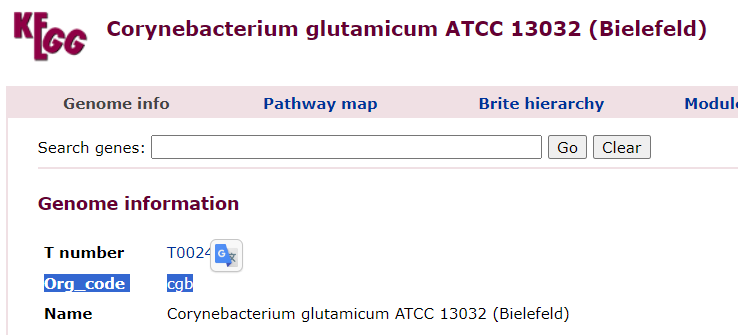

In [74]:
from bioservices import KEGG

k = KEGG()
k.organism = "cgb"

pathwayIds = k.pathwayIds
enzymeIds = k.enzymeIds
compoundIds = k.compoundIds

In [26]:
s = KEGG()
data = s.get("cgb04660")
dict_data = s.parse(data)['GENE']
type(dict_data)


WARNING [bioservices.KEGG:596]:  status is not ok with Bad Request
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


KeyError: 'GENE'